In [1]:
template = "/allen/aibs/mat/tmchartrand/bmtk_networks/biophys_components_shared/default_config.json"
folder = "/allen/aibs/mat/tmchartrand/bmtk_networks/test_manager"
# import ateam.sim.tom as sim
import ateam.sim.setup as sim
sm = sim.SimManager(config_template=template, overwrite=True, sim_folder=folder)

In [2]:
cells_dict = {
    "fs": [571709783, 529807751],
    "rs": [571700636],
    "adapting": [531520637, 488418027],
    "pc2": [525133308],
    "pc3": [508417989]
}

import numpy as np
from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.aux.node_params import positions_columinar, xiter_random
import bmtk.utils.sim_setup as setup
import bmtk.custom.batch_builder as bb
import ateam.sim.setup.default_props as defaults


net = NetworkBuilder('hcm')
sm.add_network(net)
Ne = 50
Ni = 10
height = 50

cell_id = cells_dict['pc2'][0]
net.add_nodes(N=Ne, ei='e', pop_name='e_peri',
                 positions=positions_columinar(N=Ne, center=[0, 0, 0], max_radius=30.0, height=height),
                 rotation_angle_yaxis=xiter_random(N=Ne, min_x=0.0, max_x=2*np.pi),
                 rotation_angle_zaxis=3.646878266,
                **defaults.cellprops_peri(cell_id))

cell_id = cells_dict['fs'][0]
net.add_nodes(N=Ni, ei='i', pop_name='i_peri',
                 positions=positions_columinar(N=Ni, center=[0, 0, 0], max_radius=30.0, height=height),
                 rotation_angle_yaxis=xiter_random(N=Ni, min_x=0.0, max_x=2*np.pi),
                 rotation_angle_zaxis=3.646878266,
                **defaults.cellprops_peri(cell_id))


from bmtk.builder.aux.edge_connectors import distance_connector
### Generating E-to-E connections
net.add_edges(source={'ei': 'e'}, target={'ei': 'e', 'model_type': 'biophysical'},
             connection_rule=distance_connector,
             connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
             syn_weight=2e-4,
             distance_range=[30.0, 150.0],
             target_sections=['basal', 'apical'],
             delay=2.0,
             dynamics_params='AMPA_ExcToExc.json',
             model_template='exp2syn')

### Generating I-to-I connections
net.add_edges(source={'ei': 'i'}, target={'ei': 'i', 'model_type': 'biophysical'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=2e-4,
              distance_range=[0.0, 1e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='GABA_InhToInh.json',
              model_template='exp2syn')

### Generating I-to-E connections
net.add_edges(source={'ei': 'i'}, target={'ei': 'e', 'model_type': 'biophysical'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=1.0e-4,#1.8e-4
              distance_range=[0.0, 50.0],
              target_sections=['somatic', 'basal', 'apical'],
              delay=2.0,
              dynamics_params='GABA_InhToExc.json',
              model_template='exp2syn')

### Generating E-to-I connections
net.add_edges(source={'ei': 'e'}, target={'ei': 'i', 'model_type': 'biophysical'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.26, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=1.0e-4,#3.5e-4
              distance_range=[0.0, 1e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='AMPA_ExcToInh.json',
              model_template='exp2syn')
net.build()

In [3]:
from bmtk.builder.networks import NetworkBuilder

lgn = NetworkBuilder('LGN')
sm.add_network(lgn)
lgn.add_nodes(N=500,
              pop_name='tON',
              potential='exc',
              model_type='virtual')

def select_source_cells(sources, target, nsources_min=10, nsources_max=30, nsyns_min=3, nsyns_max=12):
    total_sources = len(sources)
    nsources = np.random.randint(nsources_min, nsources_max)
    selected_sources = np.random.choice(total_sources, nsources, replace=False)
    syns = np.zeros(total_sources)
    syns[selected_sources] = np.random.randint(nsyns_min, nsyns_max, size=nsources)
    return syns

lgn.add_edges(source=lgn.nodes(), target=net.nodes(**{'ei': 'e', 'model_type': 'biophysical'}),
              iterator='all_to_one',
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 10, 'nsources_max': 25},
              syn_weight=4e-03,
              weight_function='wmax',
              distance_range=[0.0, 150.0],
              target_sections=['basal', 'apical'],
              delay=2.0,
              dynamics_params='AMPA_ExcToExc.json',
              model_template='exp2syn')

lgn.add_edges(source=lgn.nodes(), target=net.nodes(**{'ei': 'i', 'model_type': 'biophysical'}),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 15, 'nsources_max': 30},
              iterator='all_to_one',
              syn_weight=0.001,
              weight_function='wmax',
              distance_range=[0.0, 1.0e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='AMPA_ExcToInh.json',
              model_template='exp2syn')

lgn.build()

In [4]:
sm.add_network(net)
sm.add_network(lgn)
sm.save_network_files()

In [5]:
# import ateam.sim.tom as sim
# sm = sim.SimManager()
input_file = "lgn_spikes.nwb"
trial = "trial_0"
sm.add_spike_input(input_file, 'LGN', trial=trial)

In [6]:
# sm.set_sim_time(500)
# sm.run_bionet()

In [7]:
# import ateam.sim.tom as sim
# sm = sim.SimManager()
sm.set_sim_time(500)
# sm.add_ecp_report()

sm.run_bionet_mpi(ncores=4)

2018-11-08 15:04:34,294 [INFO] Created log file
2018-11-08 15:04:34,588 [INFO] Building cells.
2018-11-08 15:04:42,404 [INFO] Building recurrent connections
2018-11-08 15:04:44,193 [INFO] Build virtual cell stimulations for LGN
2018-11-08 15:04:45,241 [INFO] Running simulation for 500.000 ms with the time step 0.100 ms
2018-11-08 15:04:45,242 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2018-11-08 15:04:45,244 [INFO] Block save every 5000 steps
2018-11-08 15:04:49,801 [INFO]     step:5000 t_sim:500.00 ms
2018-11-08 15:04:50,009 [INFO] Simulation completed in 4.768 seconds 


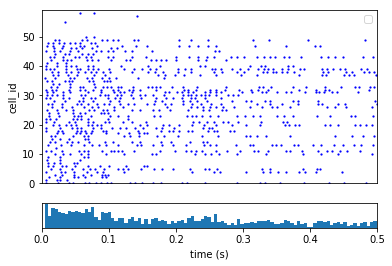

In [8]:
%matplotlib inline
# import ateam.sim.tom as sim
# sm = sim.SimManager()
sm.plot_raster('hcm')

In [12]:
from ateam.sim.run import pbstools
from ateam.sim.run import runner
options = {
    'email':'tom.chartrand@alleninstitute.org',
    'email_options':'abe',
    'jobname':'bmtk_test',
    'walltime':'00:05:00',
    'nodes':1}
command = runner.pycommand.format(config=sm.config.path)
job = pbstools.PythonJob(command=command, jobdir=sm.sim_folder, conda_env='bmtk', **options)
job.run()

#!/bin/bash
#PBS -W x=QOS:low
#PBS -q mindscope
#PBS -N bmtk_test
#PBS -M tom.chartrand@alleninstitute.org
#PBS -m abe
#PBS -r n
#PBS -l nodes=1:ppn=1
#PBS -l vmem=10g,walltime=00:05:00
#PBS -d /allen/aibs/mat/tmchartrand/bmtk_networks/test_manager
#PBS -o $PBS_JOBID.out
#PBS -e $PBS_JOBID.err
source activate bmtk
python -c "from ateam.sim.run import runner; runner.run_bionet(\"/allen/aibs/mat/tmchartrand/bmtk_networks/test_manager/config.json\")" 



''